<a href="https://colab.research.google.com/github/aren4/AhabOrtho/blob/main/Graft_Vs_No_Graft_Figures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install dataframe_image
import pandas as pd
import numpy as np
import dataframe_image as dfi
from scipy.stats import ttest_ind, fisher_exact
!pip -q install lifelines
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.offsetbox import AnnotationBbox, TextArea, VPacker
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from datetime import timedelta
import warnings

pd.set_option('display.max_columns', None)

df = pd.read_csv('/content/drive/MyDrive/MagnetOs/Graft_vs_No_Graft.csv', index_col=False, encoding='latin1')

df.head()

,Date of Surgery,MRN,DOB,Age,Sex: Male,Laterality,Graft,Race,BMI,Last Follow Up,Diff Surgery,Diff Follow Up,Follow up length (months),Concurrent Procedure,ASA,Union at 3 months,Union at 6 months,Union at 9 months,Union by 12 months,Nonunion,Infection,Revision Surgery,Diabetes,Hypertension,Cardiac Disease,Smoking Status,Alcohol Use,Cancer,CKD,Pulmonary Disease,Rheumatoid Arthritis
0,6/9/2022,367556313,2/6/1970,52.372603,M,L,0,O,25.0,3/21/2023,2.50,9.50,9.500000,1,1,8/23/2022,NaN,NaN,NaN,0,0,0,0,0,0,N,1,0,0,0,0
1,7/28/2022,440823458,7/22/1954,68.063014,F,R,0,C,21.0,1/4/2023,5.33,5.33,5.333333,0,2,NaN,1/4/2023,NaN,NaN,0,0,0,0,1,0,N,1,0,0,0,0
2,10/24/2022,470831512,7/23/1952,70.301370,F,L,0,C,24.5,8/20/2025,NaN,34.37,34.366667,1,2,NaN,NaN,NaN,NaN,1,0,1,1,1,0,N,0,0,0,0,0
3,11/3/2022,473412179,8/3/1962,60.293151,F,L,0,C,25.0,5/7/2024,NaN,18.37,18.366667,1,2,NaN,NaN,NaN,NaN,1,0,1,0,1,0,F,1,0,0,0,0
4,11/18/2022,100258000,2/9/1980,42.802740,F,L,0,B,31.0,1/13/2025,NaN,26.23,26.233333,0,3,NaN,NaN,NaN,NaN,0,0,0,0,0,0,F,1,0,0,0,0


In [2]:
# --- Cleaning and Recoding ---

df['Graft'] = df['Graft'].astype(int)

# Sex: rename & recode
df['Sex: Male'] = df['Sex: Male'].map({'M': 1, 'F': 0})

# Race: recode to categories, then one-hot
race_map = {'B': 'Black', 'W': 'Caucasian', 'C': 'Caucasian', 'O': 'Other'}
df['Race'] = df['Race'].map(race_map)
race_dummies = pd.get_dummies(df['Race'], prefix="Race")
df = pd.concat([df, race_dummies], axis=1)

# Smoking: recode then one-hot
smoke_map = {'N': 'Never', 'F': 'Former', 'C': 'Current'}
df['Smoking Status'] = df['Smoking Status'].map(smoke_map)
smoke_dummies = pd.get_dummies(df['Smoking Status'], prefix="Smoking")
df = pd.concat([df, smoke_dummies], axis=1)

# --- Define variable types ---
scalar_vars = ['Age', 'BMI', 'ASA']
binary_vars = [
    'Sex: Male',
    'Race_Black', 'Race_Caucasian', 'Race_Other',
    'Smoking_Never', 'Smoking_Former', 'Smoking_Current',
    'Nonunion', 'Infection', 'Revision Surgery', 'Diabetes',
    'Hypertension', 'Cardiac Disease', 'Alcohol Use',
    'Cancer', 'CKD', 'Pulmonary Disease', 'Rheumatoid Arthritis'
]

def safe_ttest(grp0, grp1):
    # Return NaN if any group is empty or has <2 non-NaN values (Welch's t-test needs variance)
    if (grp0.size < 2) or (grp1.size < 2):
        return np.nan
    stat, p = ttest_ind(grp0.astype(float), grp1.astype(float), equal_var=False, nan_policy="omit")
    return p

def safe_fisher(grp0, grp1):
    # grp0 and grp1 are binary (0/1) Series without NaN
    n0, n1 = grp0.size, grp1.size
    if (n0 == 0) or (n1 == 0):
        return np.nan
    a = int(grp0.sum())            # positives in group 0
    b = int(n0 - a)                # negatives in group 0
    c = int(grp1.sum())            # positives in group 1
    d = int(n1 - c)                # negatives in group 1
    # If a 2x2 table is degenerate (all zeros in a row/col), fisher_exact returns a valid p, but
    # if everything is identical (e.g., a=0=c and b>0 and d>0), it's still OK. We just run it.
    try:
        _, p = fisher_exact([[a, b], [c, d]])
        return p
    except Exception:
        return np.nan

def summarize_variable(var, is_scalar):
    res = {}

    # Prepare non-missing subsets for this variable
    sub = df[[var, 'Graft']].dropna()
    overall = sub[var]
    grp0 = sub.loc[sub['Graft'] == 0, var]
    grp1 = sub.loc[sub['Graft'] == 1, var]

    # Denominators (non-missing for this variable)
    n_tot = overall.size
    n0 = grp0.size
    n1 = grp1.size

    if is_scalar:
        # Means ± SD
        res['Total']    = f"{overall.mean():.1f} ± {overall.std():.1f}" if n_tot > 0 else "N/A"
        res['No Graft'] = f"{grp0.mean():.1f} ± {grp0.std():.1f}"       if n0 > 0 else "N/A"
        res['Graft']    = f"{grp1.mean():.1f} ± {grp1.std():.1f}"       if n1 > 0 else "N/A"
        p = safe_ttest(grp0, grp1)
        res['Test'] = "t-test"
        res['p_raw'] = p
        res['P-Value'] = f"{p:.3f}" if pd.notna(p) else "N/A"

    else:
        # Binary counts and %
        # Ensure ints
        grp0 = grp0.astype(int)
        grp1 = grp1.astype(int)
        overall = overall.astype(int)

        tot_pos = int(overall.sum())
        g0_pos = int(grp0.sum())
        g1_pos = int(grp1.sum())

        tot_pct = (tot_pos / n_tot * 100) if n_tot else np.nan
        g0_pct  = (g0_pos  / n0    * 100) if n0    else np.nan
        g1_pct  = (g1_pos  / n1    * 100) if n1    else np.nan

        res['Total']    = f"{tot_pos} ({tot_pct:.1f}%)" if pd.notna(tot_pct) else "N/A"
        res['No Graft'] = f"{g0_pos} ({g0_pct:.1f}%)"   if pd.notna(g0_pct)  else "N/A"
        res['Graft']    = f"{g1_pos} ({g1_pct:.1f}%)"   if pd.notna(g1_pct)  else "N/A"

        p = safe_fisher(grp0, grp1)
        res['Test'] = "Fisher’s exact"
        res['p_raw'] = p
        res['P-Value'] = f"{p:.3f}" if pd.notna(p) else "N/A"

    return res

# --- Build Summary Table ---
rows = []
for var in scalar_vars:
    rows.append((var, summarize_variable(var, True)))
for var in binary_vars:
    rows.append((var, summarize_variable(var, False)))

summary_df = pd.DataFrame({var: res for var, res in rows}).T
summary_df = summary_df[['Total', 'No Graft', 'Graft', 'Test', 'P-Value', 'p_raw']]

# 1) Ensure p_raw exists even if upstream code didn't add it (or it got dropped).
if 'p_raw' not in summary_df.columns:
    summary_df['p_raw'] = np.nan

# 2) Define safe subsets based on columns that truly exist right now.
visible_cols = [c for c in ['Total','No Graft','Graft','Test','P-Value'] if c in summary_df.columns]
grad_cols    = [c for c in ['p_raw'] if c in summary_df.columns]

# 3) (Optional) nicer row names if you didn’t apply them already
nice_names = {
    'Race_Black': 'Race: Black',
    'Race_Caucasian': 'Race: Caucasian',
    'Race_Other': 'Race: Other',
    'Smoking_Never': 'Smoking: Never',
    'Smoking_Former': 'Smoking: Former',
    'Smoking_Current': 'Smoking: Current',
    'Revision Surgery': 'Revision Surgery',
    'Cardiac Disease': 'Cardiac Disease',
    'Alcohol Use': 'Alcohol Use',
    'Pulmonary Disease': 'Pulmonary Disease',
    'Rheumatoid Arthritis': 'Rheumatoid Arthritis'
}
summary_df.index = [nice_names.get(x, x) for x in summary_df.index]

def style_supp_table_safe(df, visible_cols, grad_cols):
    penn_blue = "#011F5B"
    penn_red  = "#990000"
    penn_lt   = "#F1F1F1"

    sty = (
        df.style
        .set_table_styles([
            {'selector': 'thead th',
             'props': [('background-color', penn_blue),
                       ('color', 'white'),
                       ('font-weight', 'bold'),
                       ('text-align', 'center'),
                       ('border-bottom', '2px solid #000')]},
            {'selector': 'tbody th',
             'props': [('text-align', 'left')]},
            {'selector': 'tbody td',
             'props': [('text-align', 'center')]}
        ])
        .set_properties(subset=pd.IndexSlice[:, visible_cols], **{'padding': '6px 10px'})
        .format(na_rep="N/A")
    )

    # Apply significance shading only if grad_cols exist
    if grad_cols:
        sty = sty.background_gradient(subset=grad_cols, cmap='Reds', vmin=0, vmax=0.05)

        # Hide p_raw cleanly across pandas versions
        try:
            sty = sty.hide(subset=grad_cols)  # pandas ≤1.5 path
        except Exception:
            # pandas ≥2.0 path
            sty = sty.hide(axis="columns", subset=grad_cols)

    # Zebra striping for readability
    sty = sty.set_properties(**{'border-color': '#ddd'}).apply(
        lambda s: ['background-color: #fafafa' if i%2 else '' for i in range(len(s))],
        axis=1
    )

    return sty

styled = style_supp_table_safe(summary_df, visible_cols, grad_cols)

# Export
dfi.export(styled, "Table1_Demographics.png", table_conversion="matplotlib")
!cp Table1_Demographics.png "/content/drive/MyDrive/MagnetOs/Final_Figures/"

styled


,Total,No Graft,Graft,Test,P-Value
Age,65.1 ± 9.9,65.0 ± 9.4,65.1 ± 10.6,t-test,0.974
BMI,27.1 ± 3.6,27.2 ± 4.3,27.0 ± 3.0,t-test,0.874
ASA,2.2 ± 0.6,2.1 ± 0.5,2.3 ± 0.6,t-test,0.374
Sex: Male,5 (20.8%),2 (18.2%),3 (23.1%),Fisher’s exact,1.000
Race: Black,6 (25.0%),3 (27.3%),3 (23.1%),Fisher’s exact,1.000
Race: Caucasian,15 (62.5%),6 (54.5%),9 (69.2%),Fisher’s exact,0.675
Race: Other,3 (12.5%),2 (18.2%),1 (7.7%),Fisher’s exact,0.576
Smoking: Never,12 (50.0%),6 (54.5%),6 (46.2%),Fisher’s exact,1.000
Smoking: Former,10 (41.7%),4 (36.4%),6 (46.2%),Fisher’s exact,0.697
Smoking: Current,2 (8.3%),1 (9.1%),1 (7.7%),Fisher’s exact,1.000


[Diagnostics] Events parsed: 14 | Rows used in KM: 24


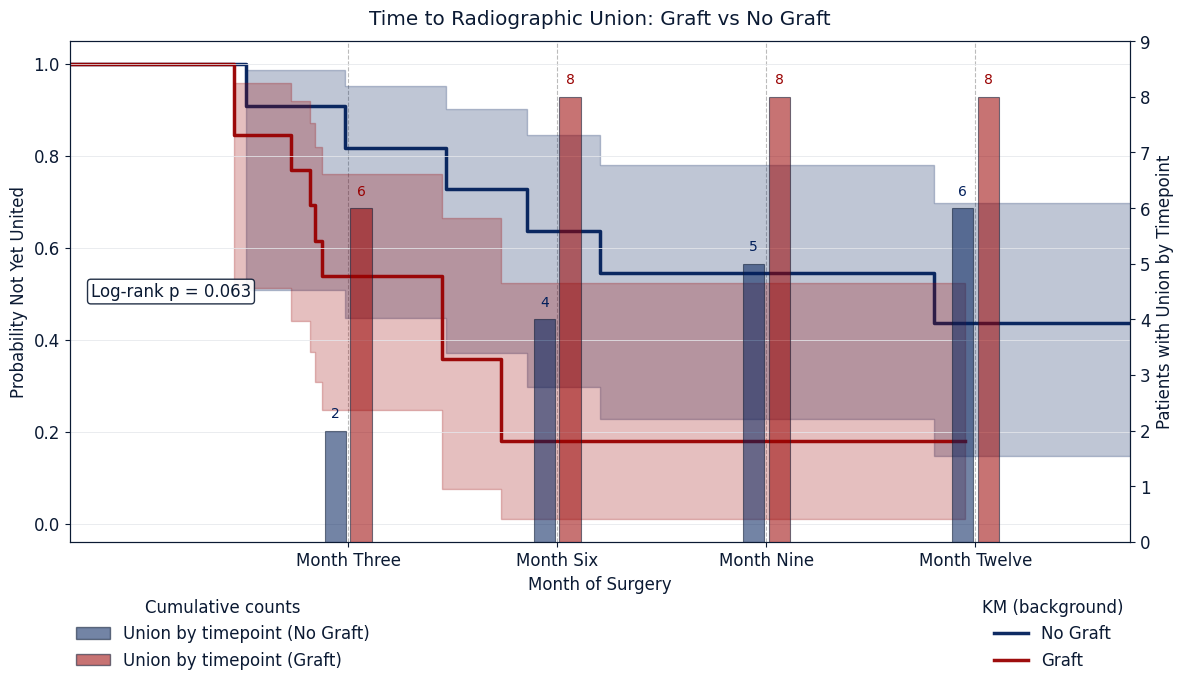

In [3]:
# ----- PARAMETERS / COLORS -----
PENN_BLUE = "#011F5B"; PENN_RED  = "#990000"; PENN_DK = "#0B1A33"
M2D = 30.44  # months → days
CUTS = [120, 210, 300, 390]  # Month Three/Six/Nine/Twelve in days
CUT_LABELS = ["Month Three", "Month Six", "Month Nine", "Month Twelve"]
X_MAX = 15 * M2D  # extend to ~15 months, unlabeled

# ----- PREP FROM NEW DIFF COLUMNS -----
df = df.copy()
df['Diff Surgery']   = pd.to_numeric(df['Diff Surgery'], errors='coerce')   # months to union
df['Diff Follow Up'] = pd.to_numeric(df['Diff Follow Up'], errors='coerce') # months to last FU

def compute_from_diffs(row):
    ds, dfu = row['Diff Surgery'], row['Diff Follow Up']
    if pd.notna(ds):   return max(ds*M2D, 0.0), 1
    if pd.notna(dfu):  return max(dfu*M2D, 0.0), 0
    return np.nan, np.nan

df['time_days'], df['event'] = zip(*df.apply(compute_from_diffs, axis=1))
df['union_days'] = np.where(pd.notna(df['Diff Surgery']), df['Diff Surgery']*M2D, np.nan)

# Diagnostics
n_events = int(pd.Series(df['event']).fillna(0).sum())
n_valid  = int(df[['time_days','event']].dropna().shape[0])
print(f"[Diagnostics] Events parsed: {n_events} | Rows used in KM: {n_valid}")

# ----- GROUPS + STATS -----
df_km = df.dropna(subset=['time_days','event','Graft']).copy()
df_km['Graft'] = df_km['Graft'].astype(int)
grp0 = df_km[df_km['Graft']==0]   # No Graft
grp1 = df_km[df_km['Graft']==1]   # Graft

p_value = logrank_test(
    grp0['time_days'], grp1['time_days'],
    event_observed_A=grp0['event'], event_observed_B=grp1['event']
).p_value

def cumulative_union_count(dsub, cutoff):
    return int((dsub['union_days'].dropna() <= cutoff).sum())

def observed_mask_at(dsub, cutoff):
    u, t = dsub['union_days'], dsub['time_days']
    return (u.notna() & (u <= cutoff)) | (t >= cutoff)

def union_nonunion_counts(dsub, cutoff):
    obs = observed_mask_at(dsub, cutoff)
    u = (dsub.loc[obs, 'union_days'].fillna(np.inf) <= cutoff).sum()
    return int(u), int(obs.sum() - u), int(obs.sum())

def fisher_p_at(d0, d1, cutoff):
    u0, n0, _ = union_nonunion_counts(d0, cutoff)
    u1, n1, _ = union_nonunion_counts(d1, cutoff)
    try:
        _, p = fisher_exact([[u0, n0], [u1, n1]])
    except Exception:
        p = np.nan
    return p, (u0, n0, u1, n1)

counts_no = [cumulative_union_count(grp0, d) for d in CUTS]
counts_gr = [cumulative_union_count(grp1, d) for d in CUTS]

# ----- FIGURE -----
plt.rcParams.update({
    "figure.figsize": (12,7), "font.size": 12,
    "axes.facecolor": "white", "axes.edgecolor": PENN_DK,
    "axes.labelcolor": PENN_DK, "text.color": PENN_DK,
    "xtick.color": PENN_DK, "ytick.color": PENN_DK
})
fig, ax = plt.subplots()

# KM curves (background)
km0 = KaplanMeierFitter(); km1 = KaplanMeierFitter()
km0.fit(grp0['time_days'], event_observed=grp0['event'], label="No Graft")
km1.fit(grp1['time_days'], event_observed=grp1['event'], label="Graft")
km0.plot(ax=ax, ci_show=True, color=PENN_BLUE, linewidth=2.5, alpha=0.95, zorder=1)
km1.plot(ax=ax, ci_show=True, color=PENN_RED,  linewidth=2.5, alpha=0.95, zorder=1)

ax.set_ylabel("Probability Not Yet United")
ax.set_xlabel("Month of Surgery")
ax.set_title("Time to Radiographic Union: Graft vs No Graft", pad=12)
ax.set_xlim(0, X_MAX)
ax.set_xticks(CUTS)
ax.set_xticklabels(CUT_LABELS)
for x in CUTS:
    ax.axvline(x, color="#BBBBBB", linestyle="--", linewidth=0.8, zorder=0)

# Bars (foreground, cumulative unions by bin)
ax2 = ax.twinx()
ax2.set_ylabel("Patients with Union by Timepoint")
bar_width = X_MAX * 0.02
offset    = bar_width * 0.6
bar_alpha = 0.55

for x, n0, n1 in zip(CUTS, counts_no, counts_gr):
    ax2.bar(x - offset, n0, width=bar_width, color=PENN_BLUE, alpha=bar_alpha,
            edgecolor=PENN_DK, linewidth=0.8, zorder=5, label="_nolegend_")
    ax2.bar(x + offset, n1, width=bar_width, color=PENN_RED,  alpha=bar_alpha,
            edgecolor=PENN_DK, linewidth=0.8, zorder=5, label="_nolegend_")

# --- Make tallest bar ≈90% of the axis height ---
max_count = max(counts_no + counts_gr) if (counts_no + counts_gr) else 0

def _nice_step(n):
    if n <= 10:  return 1
    if n <= 20:  return 2
    if n <= 50:  return 5
    if n <= 100: return 10
    return 20

def _nice_ceil(x, step):
    return int(np.ceil(x / step) * step)

target_top = max(1, max_count / 0.90)           # make tallest bar at ~90%
step       = _nice_step(target_top)              # choose a pleasant tick step
upper_y    = _nice_ceil(target_top, step)        # round up nicely

ax2.set_ylim(0, upper_y)

# (optional) if you want evenly spaced ticks:
ax2.set_yticks(np.arange(0, upper_y + step, step))

# Bar-top numeric labels
for x, n0, n1 in zip(CUTS, counts_no, counts_gr):
    ax2.text(x - offset, n0 + max(0.02*ax2.get_ylim()[1], 0.1), f"{n0}", ha='center', va='bottom', fontsize=10, color=PENN_BLUE)
    ax2.text(x + offset, n1 + max(0.02*ax2.get_ylim()[1], 0.1), f"{n1}", ha='center', va='bottom', fontsize=10, color=PENN_RED)

# Legends BELOW the figure (left/right); log-rank INSIDE mid-left
fig.subplots_adjust(bottom=0.2)
bar_legend = ax2.legend(
    handles=[Patch(facecolor=PENN_BLUE, edgecolor=PENN_DK, alpha=bar_alpha, label="Union by timepoint (No Graft)"),
             Patch(facecolor=PENN_RED,  edgecolor=PENN_DK, alpha=bar_alpha, label="Union by timepoint (Graft)")],
    loc='upper left', bbox_to_anchor=(0.00, -0.10), frameon=False, title="Cumulative counts", borderaxespad=0.
)
km_legend = ax.legend(
    loc='upper right', bbox_to_anchor=(1.00, -0.10),
    frameon=False, title="KM (background)", borderaxespad=0.
)
ax.text(0.02, 0.50, f"Log-rank p = {p_value:.3f}",
        transform=ax.transAxes, ha='left', va='center',
        bbox=dict(boxstyle="round,pad=0.2", facecolor="white", edgecolor=PENN_DK, alpha=0.9))

# Finish
ax.grid(axis='y', color="#E5E7EB", linestyle='-', linewidth=0.7, alpha=0.8); ax2.grid(False)
plt.tight_layout()
out_path = "Figure_KM_with_UnionBars_rebinned.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
!cp "Figure_KM_with_UnionBars_rebinned.png" "/content/drive/MyDrive/MagnetOs/Final_Figures/"
plt.show()


[Diagnostics] Events parsed: 14 | Rows used in KM: 24


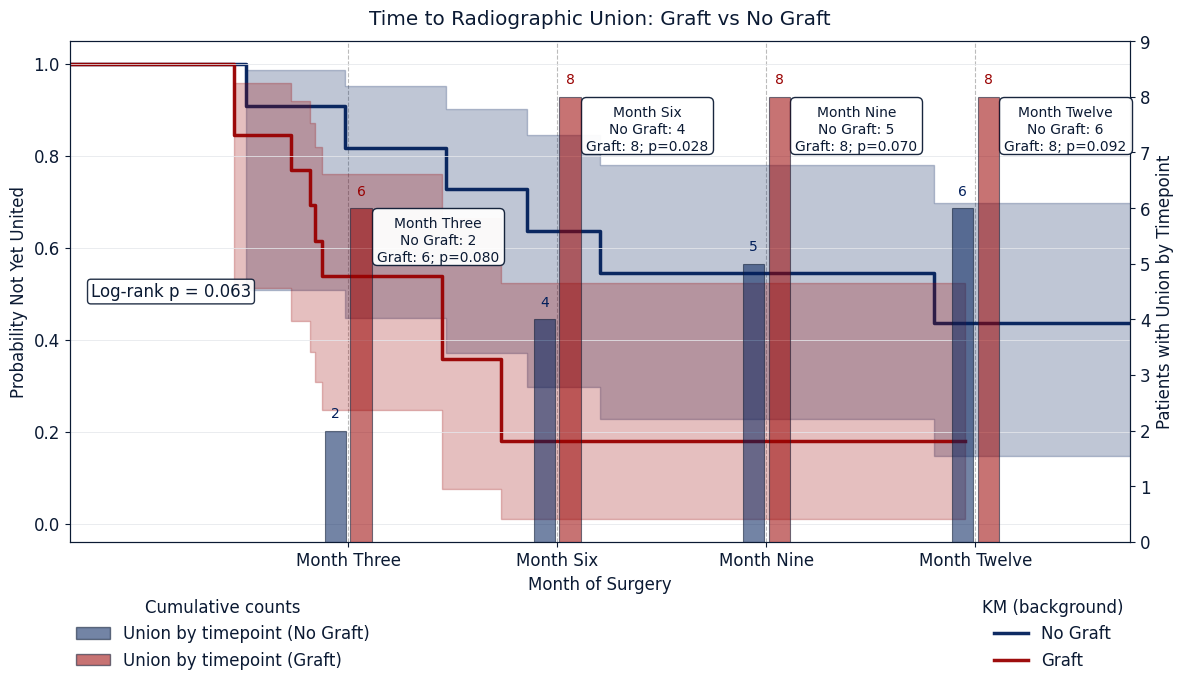

In [4]:
# ----- PARAMETERS / COLORS -----
PENN_BLUE = "#011F5B"; PENN_RED  = "#990000"; PENN_DK = "#0B1A33"
M2D = 30.44  # months → days
CUTS = [120, 210, 300, 390]  # Month Three/Six/Nine/Twelve in days
CUT_LABELS = ["Month Three", "Month Six", "Month Nine", "Month Twelve"]
X_MAX = 15 * M2D  # extend to ~15 months, unlabeled

# ----- PREP FROM NEW DIFF COLUMNS -----
df = df.copy()
df['Diff Surgery']   = pd.to_numeric(df['Diff Surgery'], errors='coerce')   # months to union
df['Diff Follow Up'] = pd.to_numeric(df['Diff Follow Up'], errors='coerce') # months to last FU

def compute_from_diffs(row):
    ds, dfu = row['Diff Surgery'], row['Diff Follow Up']
    if pd.notna(ds):   return max(ds*M2D, 0.0), 1
    if pd.notna(dfu):  return max(dfu*M2D, 0.0), 0
    return np.nan, np.nan

df['time_days'], df['event'] = zip(*df.apply(compute_from_diffs, axis=1))
df['union_days'] = np.where(pd.notna(df['Diff Surgery']), df['Diff Surgery']*M2D, np.nan)

# Diagnostics
n_events = int(pd.Series(df['event']).fillna(0).sum())
n_valid  = int(df[['time_days','event']].dropna().shape[0])
print(f"[Diagnostics] Events parsed: {n_events} | Rows used in KM: {n_valid}")

# ----- GROUPS + STATS -----
df_km = df.dropna(subset=['time_days','event','Graft']).copy()
df_km['Graft'] = df_km['Graft'].astype(int)
grp0 = df_km[df_km['Graft']==0]   # No Graft
grp1 = df_km[df_km['Graft']==1]   # Graft

p_value = logrank_test(
    grp0['time_days'], grp1['time_days'],
    event_observed_A=grp0['event'], event_observed_B=grp1['event']
).p_value

def cumulative_union_count(dsub, cutoff):
    return int((dsub['union_days'].dropna() <= cutoff).sum())

def observed_mask_at(dsub, cutoff):
    u, t = dsub['union_days'], dsub['time_days']
    return (u.notna() & (u <= cutoff)) | (t >= cutoff)

def union_nonunion_counts(dsub, cutoff):
    obs = observed_mask_at(dsub, cutoff)
    u = (dsub.loc[obs, 'union_days'].fillna(np.inf) <= cutoff).sum()
    return int(u), int(obs.sum() - u), int(obs.sum())

def fisher_p_at(d0, d1, cutoff):
    u0, n0, _ = union_nonunion_counts(d0, cutoff)
    u1, n1, _ = union_nonunion_counts(d1, cutoff)
    try:
        _, p = fisher_exact([[u0, n0], [u1, n1]])
    except Exception:
        p = np.nan
    return p, (u0, n0, u1, n1)

counts_no = [cumulative_union_count(grp0, d) for d in CUTS]
counts_gr = [cumulative_union_count(grp1, d) for d in CUTS]

# ----- FIGURE -----
plt.rcParams.update({
    "figure.figsize": (12,7), "font.size": 12,
    "axes.facecolor": "white", "axes.edgecolor": PENN_DK,
    "axes.labelcolor": PENN_DK, "text.color": PENN_DK,
    "xtick.color": PENN_DK, "ytick.color": PENN_DK
})
fig, ax = plt.subplots()

# KM curves (background)
km0 = KaplanMeierFitter(); km1 = KaplanMeierFitter()
km0.fit(grp0['time_days'], event_observed=grp0['event'], label="No Graft")
km1.fit(grp1['time_days'], event_observed=grp1['event'], label="Graft")
km0.plot(ax=ax, ci_show=True, color=PENN_BLUE, linewidth=2.5, alpha=0.95, zorder=1)
km1.plot(ax=ax, ci_show=True, color=PENN_RED,  linewidth=2.5, alpha=0.95, zorder=1)

ax.set_ylabel("Probability Not Yet United")
ax.set_xlabel("Month of Surgery")
ax.set_title("Time to Radiographic Union: Graft vs No Graft", pad=12)
ax.set_xlim(0, X_MAX)
ax.set_xticks(CUTS)
ax.set_xticklabels(CUT_LABELS)
for x in CUTS:
    ax.axvline(x, color="#BBBBBB", linestyle="--", linewidth=0.8, zorder=0)

# Bars (foreground, cumulative unions by bin)
ax2 = ax.twinx()
ax2.set_ylabel("Patients with Union by Timepoint")
bar_width = X_MAX * 0.02
offset    = bar_width * 0.6
bar_alpha = 0.55

for x, n0, n1 in zip(CUTS, counts_no, counts_gr):
    ax2.bar(x - offset, n0, width=bar_width, color=PENN_BLUE, alpha=bar_alpha,
            edgecolor=PENN_DK, linewidth=0.8, zorder=5, label="_nolegend_")
    ax2.bar(x + offset, n1, width=bar_width, color=PENN_RED,  alpha=bar_alpha,
            edgecolor=PENN_DK, linewidth=0.8, zorder=5, label="_nolegend_")

# --- Make tallest bar ≈90% of the axis height ---
max_count = max(counts_no + counts_gr) if (counts_no + counts_gr) else 0

def _nice_step(n):
    if n <= 10:  return 1
    if n <= 20:  return 2
    if n <= 50:  return 5
    if n <= 100: return 10
    return 20

def _nice_ceil(x, step):
    return int(np.ceil(x / step) * step)

target_top = max(1, max_count / 0.90)           # make tallest bar at ~90%
step       = _nice_step(target_top)              # choose a pleasant tick step
upper_y    = _nice_ceil(target_top, step)        # round up nicely

ax2.set_ylim(0, upper_y)

# (optional) if you want evenly spaced ticks:
ax2.set_yticks(np.arange(0, upper_y + step, step))

# Bar-top numeric labels
for x, n0, n1 in zip(CUTS, counts_no, counts_gr):
    ax2.text(x - offset, n0 + max(0.02*ax2.get_ylim()[1], 0.1), f"{n0}", ha='center', va='bottom', fontsize=10, color=PENN_BLUE)
    ax2.text(x + offset, n1 + max(0.02*ax2.get_ylim()[1], 0.1), f"{n1}", ha='center', va='bottom', fontsize=10, color=PENN_RED)

# Annotations: three-line boxes, UL corner aligned to right bar’s UR corner
right_edges_x = [x + offset + (bar_width/2.0) for x in CUTS]
for i, (cut, x_right) in enumerate(zip(CUTS, right_edges_x)):
    y_top_right = counts_gr[i]
    p_tp, (u0, _n0, u1, _n1) = fisher_p_at(grp0, grp1, cut)
    line1 = TextArea(CUT_LABELS[i], textprops=dict(ha='center', va='center', fontsize=10, color=PENN_DK))
    line2 = TextArea(f"No Graft: {u0}", textprops=dict(ha='center', va='center', fontsize=10, color=PENN_DK))
    line3 = TextArea(f"Graft: {u1}; p={p_tp:.3f}" if not np.isnan(p_tp) else f"Graft: {u1}",
                     textprops=dict(ha='center', va='center', fontsize=10, color=PENN_DK))
    packed = VPacker(children=[line1, line2, line3], align="center", pad=0, sep=2)
    ab = AnnotationBbox(
        packed, (x_right, y_top_right),
        xycoords=ax2.transData,
        box_alignment=(-0.045, 1.1),  # box UL corner pinned to bar UR
        frameon=True,
        bboxprops=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor=PENN_DK, alpha=0.95)
    )
    ax2.add_artist(ab)

# Legends BELOW the figure (left/right); log-rank INSIDE mid-left
fig.subplots_adjust(bottom=0.2)
bar_legend = ax2.legend(
    handles=[Patch(facecolor=PENN_BLUE, edgecolor=PENN_DK, alpha=bar_alpha, label="Union by timepoint (No Graft)"),
             Patch(facecolor=PENN_RED,  edgecolor=PENN_DK, alpha=bar_alpha, label="Union by timepoint (Graft)")],
    loc='upper left', bbox_to_anchor=(0.00, -0.10), frameon=False, title="Cumulative counts", borderaxespad=0.
)
km_legend = ax.legend(
    loc='upper right', bbox_to_anchor=(1.00, -0.10),
    frameon=False, title="KM (background)", borderaxespad=0.
)
ax.text(0.02, 0.50, f"Log-rank p = {p_value:.3f}",
        transform=ax.transAxes, ha='left', va='center',
        bbox=dict(boxstyle="round,pad=0.2", facecolor="white", edgecolor=PENN_DK, alpha=0.9))

# Finish
ax.grid(axis='y', color="#E5E7EB", linestyle='-', linewidth=0.7, alpha=0.8); ax2.grid(False)
plt.tight_layout()
out_path = "Figure_KM_with_UnionBars_rebinned.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
!cp "Figure_KM_with_UnionBars_rebinned.png" "/content/drive/MyDrive/MagnetOs/Final_Figures/"
plt.show()


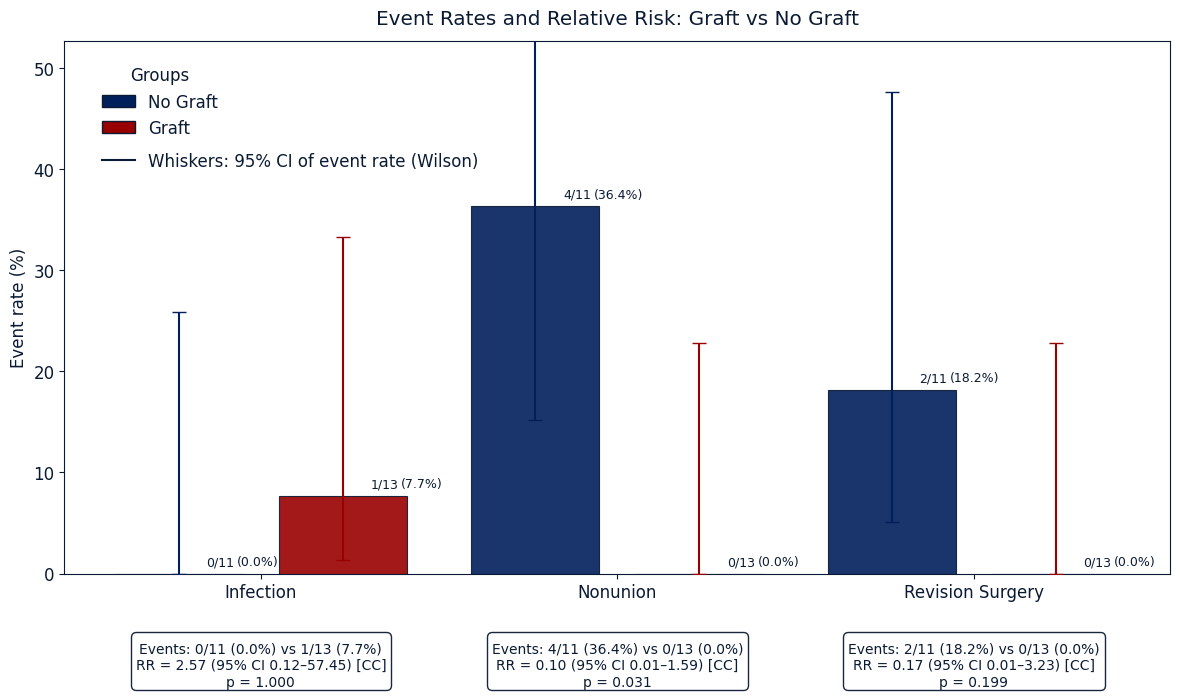

In [5]:
  # --- 3-outcome bar chart with counts + rates, RR (with continuity correction), and annotations ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.offsetbox import AnnotationBbox, TextArea, VPacker
from matplotlib.transforms import blended_transform_factory
from scipy.stats import fisher_exact

df = df.copy()
df['Graft'] = pd.to_numeric(df['Graft'], errors='coerce').astype('Int64')

# Ensure outcomes exist and are numeric 0/1
for col in ['Infection', 'Nonunion', 'Revision Surgery']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')

# Penn palette
PENN_BLUE = "#011F5B"
PENN_RED  = "#990000"
PENN_DK   = "#0B1A33"

outcomes = [
    ("Infection",        "Infection"),
    ("Nonunion",         "Nonunion"),
    ("Revision Surgery", "Revision Surgery"),
]

def wilson_ci(k, n, z=1.96):
    if n is None or pd.isna(n) or n == 0:
        return (np.nan, np.nan)
    p = k / n
    denom = 1 + z**2 / n
    center = (p + z**2/(2*n)) / denom
    half = (z * np.sqrt(p*(1-p)/n + z**2/(4*n**2))) / denom
    return max(0, center - half), min(1, center + half)

def rr_ci(a, b, c, d, z=1.96):
    """
    2x2 with Graft (exposed): a=events_graft, b=non-events_graft
                             Control (No Graft): c=events_nograft, d=non-events_nograft
    Haldane–Anscombe 0.5 continuity correction applied if ANY cell is zero.
    Returns: rr, (lo, hi), used_correction(bool)
    """
    used_corr = False
    if min(a, b, c, d) == 0:
        a += 0.5; b += 0.5; c += 0.5; d += 0.5
        used_corr = True
    risk1 = a / (a + b)
    risk0 = c / (c + d)
    if risk0 == 0:
        return np.nan, (np.nan, np.nan), used_corr
    rr = risk1 / risk0
    # log RR CI
    se = np.sqrt((1/a) - (1/(a+b)) + (1/c) - (1/(c+d)))
    lo = np.exp(np.log(rr) - z*se)
    hi = np.exp(np.log(rr) + z*se)
    return rr, (lo, hi), used_corr

def counts_for_col(col):
    sub = df[['Graft', col]].dropna()
    g0 = sub[sub['Graft']==0][col].astype(int)
    g1 = sub[sub['Graft']==1][col].astype(int)
    a0 = int(g0.sum()); n0 = int(g0.shape[0])  # No Graft
    a1 = int(g1.sum()); n1 = int(g1.shape[0])  # Graft
    return (a0, n0, a1, n1)

# Compute stats
pairs = []
for col, label in outcomes:
    a0, n0, a1, n1 = counts_for_col(col)
    p0 = a0/n0 if n0 else np.nan
    p1 = a1/n1 if n1 else np.nan
    l0, u0 = wilson_ci(a0, n0)
    l1, u1 = wilson_ci(a1, n1)
    rr, (rr_lo, rr_hi), used_corr = rr_ci(a1, n1-a1, a0, n0-a0)
    try:
        _, pval = fisher_exact([[a1, n1-a1],[a0, n0-a0]])
    except Exception:
        pval = np.nan
    pairs.append({
        'label': label,
        'a0': a0, 'n0': n0, 'p0': p0, 'ci0': (l0, u0),
        'a1': a1, 'n1': n1, 'p1': p1, 'ci1': (l1, u1),
        'rr': rr, 'rr_ci': (rr_lo, rr_hi), 'p': pval, 'rr_corr': used_corr
    })

# Figure
plt.rcParams.update({
    "figure.figsize": (12, 7),
    "axes.facecolor": "white",
    "axes.edgecolor": PENN_DK,
    "axes.labelcolor": PENN_DK,
    "text.color": PENN_DK,
    "xtick.color": PENN_DK,
    "ytick.color": PENN_DK,
    "font.size": 12
})
fig, ax = plt.subplots()

indices = np.arange(len(pairs))
bar_w = 0.36
gap = 0.10
x_no  = indices - (bar_w/2 + gap/2)
x_gr  = indices + (bar_w/2 + gap/2)

# Heights in percent
heights_no = [p['p0']*100 if p['p0']==p['p0'] else np.nan for p in pairs]
heights_gr = [p['p1']*100 if p['p1']==p['p1'] else np.nan for p in pairs]

# Wilson CI (percent) → errorbar deltas (nonnegative, NaN-safe)
def yerr_from_wilson_sanitized(heights, cis):
    lower, upper = [], []
    for h, ci in zip(heights, cis):
        if (ci is None) or (np.isnan(h)) or (ci[0] is None) or (ci[1] is None) or np.isnan(ci[0]) or np.isnan(ci[1]):
            lower.append(0.0); upper.append(0.0)
        else:
            lo_pct = float(ci[0]) * 100.0
            hi_pct = float(ci[1]) * 100.0
            # Clamp in case of tiny numeric inversions (ensure no negatives)
            lower.append(max(h - lo_pct, 0.0))
            upper.append(max(hi_pct - h, 0.0))
    return np.vstack([lower, upper]).astype(float)

yerr_no = yerr_from_wilson_sanitized(heights_no, [p['ci0'] for p in pairs])
yerr_gr = yerr_from_wilson_sanitized(heights_gr, [p['ci1'] for p in pairs])

# Bars
bars_no = ax.bar(x_no, heights_no, width=bar_w, color=PENN_BLUE, alpha=0.9,
                 edgecolor=PENN_DK, linewidth=0.8, label="No Graft", zorder=3)
bars_gr = ax.bar(x_gr, heights_gr, width=bar_w, color=PENN_RED,  alpha=0.9,
                 edgecolor=PENN_DK, linewidth=0.8, label="Graft",    zorder=3)

# Whiskers (95% CI for rate)
ax.errorbar(x_no, heights_no, yerr=yerr_no, fmt='none', ecolor=PENN_BLUE, elinewidth=1.5, capsize=5, zorder=4)
ax.errorbar(x_gr, heights_gr, yerr=yerr_gr, fmt='none', ecolor=PENN_RED,  elinewidth=1.5, capsize=5, zorder=4)

# Axis cosmetics
ax.set_xticks(indices)
ax.set_xticklabels([p['label'] for p in pairs])
ax.set_ylabel("Event rate (%)")
ax.set_title("Event Rates and Relative Risk: Graft vs No Graft", pad=12)

ymax = max([v for v in (heights_no + heights_gr) if not np.isnan(v)] + [1])
ax.set_ylim(0, ymax * 1.45)

# --- Labels on each bar: move BOTH counts and percent to the right ---
def fmt_pct(x):
    return "N/A" if np.isnan(x) else f"{x:.1f}%"

x_dx_pts   = 20  # base rightward offset (points) applied to BOTH labels
pct_gap_pts = 22  # extra rightward gap for percent relative to counts
y_inset_pts = 0  # set to a small negative/positive value if you want to tweak vertical position in points

for i, (bn, bg, info) in enumerate(zip(bars_no, bars_gr, pairs)):
    for bar, a, n, pct, inside_color in [
        (bn, info['a0'], info['n0'], info['p0']*100 if info['p0']==info['p0'] else np.nan, 'white'),
        (bg, info['a1'], info['n1'], info['p1']*100 if info['p1']==info['p1'] else np.nan, 'white'),
    ]:
        h = bar.get_height()
        x_center = bar.get_x() + bar.get_width()/2

        y_counts = h + 0.01 * ax.get_ylim()[1]
        va_counts = 'bottom'
        color_counts = PENN_DK
        color_pct = PENN_DK

        # 1) Counts, moved right by x_dx_pts
        ax.annotate(f"{a}/{n}",
                    xy=(x_center, y_counts), xycoords=ax.transData,
                    xytext=(x_dx_pts, y_inset_pts), textcoords='offset points',
                    ha='left', va=va_counts, fontsize=9, color=color_counts)

        # 2) Percentage, same base shift + a small extra gap
        ax.annotate(f"({fmt_pct(pct)})",
                    xy=(x_center, y_counts), xycoords=ax.transData,
                    xytext=(x_dx_pts + pct_gap_pts, y_inset_pts), textcoords='offset points',
                    ha='left', va=va_counts, fontsize=9, color=color_pct)



# Make room below the axes for the three annotation boxes
fig.subplots_adjust(bottom=0.32)

# Mixed transform: x in DATA units (to sit under each pair), y in AXES fraction (to sit below axes)
trans_xdata_yaxes = blended_transform_factory(ax.transData, ax.transAxes)

# --- Move the three stats boxes BELOW their respective pairs (centered under each pair) ---
# Use the same content as before (counts+rates, RR w/ 95% CI and [CC] flag, Fisher p)
def fmt_pct(x): return "N/A" if np.isnan(x) else f"{x:.1f}%"

y_box_top = -0.12  # top of each box at 12% of axes height below the bottom edge
for i, info in enumerate(pairs):
    x_mid = (x_no[i] + x_gr[i]) / 2  # centered under the pair

    line1 = TextArea(
        f"Events: {info['a0']}/{info['n0']} ({fmt_pct(info['p0']*100 if info['p0']==info['p0'] else np.nan)})"
        f" vs {info['a1']}/{info['n1']} ({fmt_pct(info['p1']*100 if info['p1']==info['p1'] else np.nan)})",
        textprops=dict(ha='center', va='center', fontsize=10, color=PENN_DK)
    )

    if info['rr']==info['rr'] and info['rr_ci'][0]==info['rr_ci'][0] and info['rr_ci'][1]==info['rr_ci'][1]:
        rr_line = f"RR = {info['rr']:.2f} (95% CI {info['rr_ci'][0]:.2f}–{info['rr_ci'][1]:.2f})"
        if info['rr_corr']:
            rr_line += " [CC]"
    else:
        rr_line = "RR = N/A"
    line2 = TextArea(rr_line, textprops=dict(ha='center', va='center', fontsize=10, color=PENN_DK))

    p_txt = "p = N/A" if not (info['p']==info['p']) else f"p = {info['p']:.3f}"
    line3 = TextArea(p_txt, textprops=dict(ha='center', va='center', fontsize=10, color=PENN_DK))

    packed = VPacker(children=[line1, line2, line3], align="center", pad=0, sep=2)

    # Anchor is (x_mid, y_box_top) in mixed coords; box's TOP-CENTER sits on that anchor
    ab = AnnotationBbox(
        packed,
        (x_mid, y_box_top),
        xycoords=trans_xdata_yaxes,
        box_alignment=(0.5, 1.0),  # top-center of box pinned to anchor
        frameon=True,
        bboxprops=dict(boxstyle="round,pad=0.3", facecolor="white",
                       edgecolor=PENN_DK, alpha=0.95),
        clip_on=False  # allow the box to live outside the axes
    )
    ax.add_artist(ab)

# --- Stack legends INSIDE the figure, top-left ---
# 1) Group colors
bar_legend = ax.legend(
    handles=[Patch(facecolor=PENN_BLUE, edgecolor=PENN_DK, label="No Graft"),
             Patch(facecolor=PENN_RED,  edgecolor=PENN_DK, label="Graft")],
    loc='upper left', bbox_to_anchor=(0.02, 0.98), frameon=False, title="Groups"
)

# 2) CI explainer (stacked just below the group legend)
ci_handle = Line2D([0],[0], color=PENN_DK, lw=1.5)
ci_legend = ax.legend(
    handles=[ci_handle],
    labels=["Whiskers: 95% CI of event rate (Wilson)"],
    loc='upper left', bbox_to_anchor=(0.02, 0.82), frameon=False
)
ax.add_artist(bar_legend)

plt.tight_layout()
out_path = "Figure_RR_Bars_counts_rates_v2.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
!cp "Figure_RR_Bars_counts_rates_v2.png" "/content/drive/MyDrive/MagnetOs/Final_Figures/"
plt.show()
